# Visualizations for Embeddings

In [ ]:
# Note: you may need to restart the kernel to use updated packages.
%pip install --upgrade whylogs[embeddings,viz]

In [1]:
import os
import pickle
from sklearn.datasets import fetch_openml

if os.path.exists("mnist_784_X_y.pkl"):
    X, y = pickle.load(open("mnist_784_X_y.pkl", 'rb'))
else:
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_prod, y_train, y_prod = train_test_split(X, y, test_size=0.1)

In [3]:
from whylogs.experimental.preprocess.embeddings.selectors import PCACentroidsSelector

references, labels = PCACentroidsSelector(n_components=20).calculate_references(X_train, y_train)

In [4]:
from whylogs.experimental.preprocess.embeddings.selectors import PCAKMeansSelector

unsup_references, unsup_labels = PCAKMeansSelector(n_clusters=8, n_components=20).calculate_references(X_train, y_train)

In [5]:
import whylogs as why
from whylogs.core.resolvers import MetricSpec, ResolverSpec
from whylogs.core.schema import DeclarativeSchema
from whylogs.experimental.extras.embedding_metric import (
    DistanceFunction,
    EmbeddingConfig,
    EmbeddingMetric,
)

config = EmbeddingConfig(
    references=references,
    labels=labels,
    distance_fn=DistanceFunction.euclidean,
)
schema = DeclarativeSchema([ResolverSpec(column_name="pixel_values", metrics=[MetricSpec(EmbeddingMetric, config)])])

train_profile = why.log(row={"pixel_values": X_train}, schema=schema)

In [6]:
train_profile_view = train_profile.view()
column = train_profile_view.get_column("pixel_values")
summary = column.to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean = summary[f'embedding/{digit}_distance:distribution/mean']
    stddev = summary[f'embedding/{digit}_distance:distribution/stddev']
    print(f"{digit} distance: mean {mean}   stddev {stddev}")

0 distance: mean 2189.6418495867256   stddev 202.13673017035543
1 distance: mean 2064.9635529764782   stddev 471.60217972001726
2 distance: mean 1994.9138799821183   stddev 234.03855013982923
3 distance: mean 1998.16538766786   stddev 274.4547869057699
4 distance: mean 1978.2571493207238   stddev 304.5624102231718
5 distance: mean 1911.2204018465584   stddev 254.3123964411137
6 distance: mean 2025.3644611446455   stddev 259.2599325453731
7 distance: mean 2013.259484489203   stddev 348.9192388746262
8 distance: mean 1937.584275322155   stddev 262.78833584835866
9 distance: mean 1944.0574469857886   stddev 328.8241463693296


In [7]:
# Find which digits have more than or equal to 90% missing
not_empty_mask = (X_prod == 0).sum(axis=1) <= (0.9 * 784)
X_prod = X_prod[not_empty_mask]
y_prod = y_prod[not_empty_mask]

In [8]:
# Log production digits using the same schema
prod_profile_view = why.log(row={"pixel_values": X_prod}, schema=schema).profile().view()

In [9]:
train_profile_summary = train_profile_view.get_column("pixel_values").to_summary_dict()
prod_profile_summary = prod_profile_view.get_column("pixel_values").to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean_diff = train_profile_summary[f'embedding/{digit}_distance:distribution/mean'] - prod_profile_summary[f'embedding/{digit}_distance:distribution/mean']
    stddev_diff = train_profile_summary[f'embedding/{digit}_distance:distribution/stddev'] - prod_profile_summary[f'embedding/{digit}_distance:distribution/stddev']
    print(f"{digit} distance difference (target-prod): mean {mean_diff}   stddev {stddev_diff}")

0 distance difference (target-prod): mean 3.96116447088707   stddev -6.1459506229792
1 distance difference (target-prod): mean -50.72126245378013   stddev 43.69356529036776
2 distance difference (target-prod): mean -13.66717331797713   stddev -0.4247887578197549
3 distance difference (target-prod): mean -10.405837993823525   stddev -0.002002256529067381
4 distance difference (target-prod): mean -11.001853453387639   stddev -7.205934877985442
5 distance difference (target-prod): mean -12.051755683900865   stddev 3.3034093330448684
6 distance difference (target-prod): mean -11.366926324043334   stddev -3.8786118176914783
7 distance difference (target-prod): mean -19.12737367760633   stddev -0.8735783350825841
8 distance difference (target-prod): mean -12.427421841100795   stddev -3.747510575270155
9 distance difference (target-prod): mean -12.906888795371742   stddev -5.036286777726559


# Visualizations
Compare this to the raw data visualization. Note the locations of the labels matches the labels below.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

class ReferenceSelector:
    def __init__(self):
        self.n_references = 0
        self.ref_labels = None

    def calculate_references(self, X: np.array, y: np.array):
        raise NotImplementedError()

class EmbeddingsAnalysis:
    distance_fns = {'euclidean': euclidean_distances, 'cosine': cosine_distances}

    def __init__(self, X, y=None, 
                 distance='cosine'):
                 #reference_selector: ReferenceSelector = PCACentroids(n_components=2)):
        if distance not in EmbeddingsAnalysis.distance_fns:
            raise ValueError(f"Distance not valid. Choose one of {list(EmbeddingsAnalysis.distance_fns.keys())}.")
        self.X = X
        self.y = y
        self.labels = sorted(np.unique(y))
        self.distance_method = EmbeddingsAnalysis.distance_fns[distance]
        self.plot_pca = None
        self.X_plot_pca = None
        self.refs_plot_pca = None
        self.X_ref_dists = None
        self.X_ref_closest = None

        print("Calculating references...", end=" ")
        self.refs = references
        self.n_references = len(references)
        self.ref_labels = labels
        print("Done.")

        print("Calculating distances from data points to references...", end=" ")
        self.X_ref_dists = self.distance_method(self.X, self.refs)
        print("Done.")

        print("Finding closest reference for each data point...", end=" ")
        self.X_ref_closest = np.argmin(self.X_ref_dists, axis=1)
        print("Done.")

    def plot(self, X = None, y = None, n: int = 1000, show_references: bool = True, method: str = 'pca'):
        if self.X_plot_pca is None:
            print("Fitting PCA to data for plot for all data...", end=" ")
            # Fit PCA
            self.plot_pca = PCA(n_components=2)
            self.X_plot_pca = self.plot_pca.fit_transform(self.X)
            print("Done.")
        
        X_plot = self.X_plot_pca if X is None else self.plot_pca.transform(X)

        show_hue = True
        if X is None:
            y_plot = self.y
        elif y is not None:
            y_plot = y
        else:
            show_hue = False
            y_plot = np.zeros(len(X_plot))

        fig, ax = plt.subplots()
        
        if show_hue:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], hue=y_plot[:n], s=20, ax=ax)
        else:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], s=20, ax=ax)
        
        if show_references and self.refs is not None:
            if self.refs_plot_pca is None:
                self.refs_plot_pca = self.plot_pca.transform(self.refs)
            sns.scatterplot(x=self.refs_plot_pca[:, 0], y=self.refs_plot_pca[:, 1], color="black", marker="X", s=0, ax=ax)
            # centroid labels
            for i, ref_label in enumerate(self.ref_labels):
                plt.text(x=self.refs_plot_pca[i, 0], y=self.refs_plot_pca[i, 1], s=str(ref_label), horizontalalignment='center', 
                        color='black', weight='bold')
    
    def plot_3d_quiver(self):
        from matplotlib.colors import ListedColormap
        print("Fitting PCA to data for plot for all data...", end=" ")
        # Fit PCA
        plot_model = PCA(n_components=3)
        X_plot = plot_model.fit_transform(self.X)
        print("Done.")
        
        y_plot = self.y
        cmap = ListedColormap(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"])

        
        ax = plt.axes(projection='3d')
        ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=50, c=np.random.choice(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"], X_plot.shape[0]))

        ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], s=50, c=np.random.choice(["#f4843c", "#ffde1e", "#005566", "#44c3e3", "#2783c7"], X_plot.shape[0]))

        ax.set_xlim([-5,5])
        ax.set_ylim([-5,5])
        ax.set_zlim([-5,5])
        
        # centroid labels
        for ref_label, x, y, z in zip(word_list, X_plot[:, 0], X_plot[:, 1], X_plot[:, 2]):
            if ref_label in ["hyperparameter", "dataframe"]: continue
            if ref_label == "varianc": ref_label = "variance"
            ax.text(x, y, z, s="    "+ref_label, color='black', fontsize=6)

    def plot_reference_distances(self, X = None, n: int = 1000):
        X_plot = self.X_ref_dists if X is None else self.distance_method(X, self.refs)
        
        return sns.displot(data=pd.melt(pd.DataFrame(X_plot[:n]), var_name="Reference index", value_name="Distance"),
                               x="Distance", col="Reference index", col_wrap=2, kind='kde', height=1, aspect=3)

    def plot_closest_references_by_label(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None: 
            n = len(X_plot)
        
        closest_ref_count_by_label = []
        for label in self.labels:
            closest_ref_count_by_label.append(np.bincount(X_plot[:n][y_plot[:n]==label], 
                                                          minlength=self.n_references))
        closest_ref_count_by_label = np.array(closest_ref_count_by_label)

        return sns.heatmap(closest_ref_count_by_label, annot=True, fmt=".0f", linewidth=1, linecolor='w').set(xlabel="Closest reference", ylabel="True label")
    
    def plot_closest_references(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None:
            n = len(X_plot)
        closest_ref_count = np.bincount(X_plot[:n], minlength=self.n_references)

        return sns.barplot(x=list(range(self.n_references)), y=closest_ref_count
                          ).set(xlabel="Reference index", ylabel="Closest count")

Calculating references... Done.
Calculating distances from data points to references... Done.
Finding closest reference for each data point... Done.
Fitting PCA to data for plot for all data... Done.


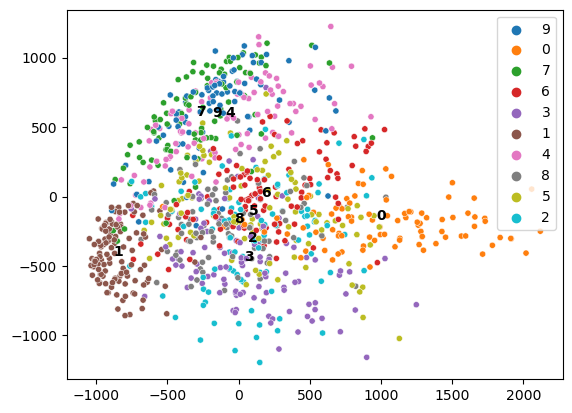

In [76]:
b = EmbeddingsAnalysis(X_train, y_train, distance='cosine')
b.plot()

# Bubble Scatterplot
Without column labels, we will see a basic bubble scatterplot all the same color. (We could color it, but it will be confused with the next iteration.)

In [47]:
prod_profile_view.get_column(col_name="pixel_values").get_metric("embedding").

EmbeddingMetric(references=<whylogs.experimental.extras.matrix_component.MatrixComponent object at 0x7fee017b76d0>, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], distance_fn=<function euclidean_distances at 0x7fee29ec2040>, serialize_references=True)

In [77]:
# Dimensionality reduction for plotting
# This is a noteworthy aspect -- we should consider keeping the transformation model from the raw data.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

<AxesSubplot:xlabel='x', ylabel='y'>

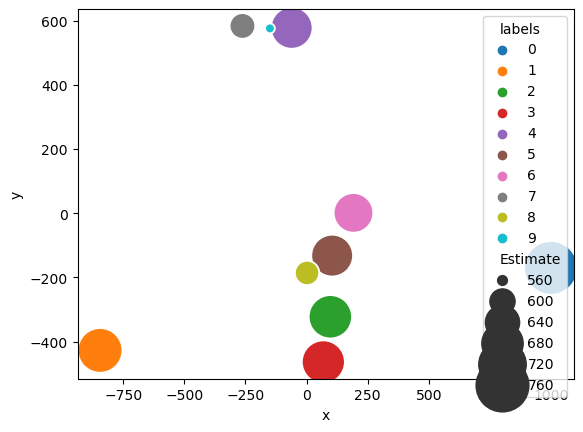

In [80]:
import pandas as pd
import seaborn as sns
from whylogs_sketching import NO_FALSE_POSITIVES

bubble_data = pd.DataFrame(prod_profile_view.get_column(col_name="pixel_values") \
              .get_metric("embedding").submetrics["closest"]["frequent_items"] \
              .frequent_strings.value.get_frequent_items(err_type=NO_FALSE_POSITIVES), \
                  columns=["Count", "LB", "Estimate", "UB"])
bubble_data["labels"] = labels

pca_refs = pca.transform(references)
bubble_data["x"] = pca_refs[:, 0]
bubble_data["y"] = pca_refs[:, 1]

# If we DON'T have reference data available, we'll see the bubbles one by one
sns.scatterplot(data=bubble_data, x="x", y="y", size="Estimate", hue="labels",
                legend=True, sizes=(50, 1500))

The above view raises some questions:
* Do we want to additionally track a better representative of the size/shape of each cluster?

# Bubble Scatterplot
Without column labels, we will see a basic bubble scatterplot all the same color. (We could color it, but it will be confused with the next iteration.)

# Circle packing Scatterplot

When we are able to multi-column, we'd like to pair the prediction with the embeddings. This is the most common analysis with this sort of chart.

In [ ]:
import circlify

#for ref in pca_refs:
#circles = circlify.circlify(
#    bubble_plot.loc[ref, :], 
#    show_enclosure=True, 
#    target_enclosure=circlify.Circle(x=0, y=0, r=1)
#)